In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading dataset

In [ ]:
df = pd.read_csv("drive/MyDrive/training/HW/data/bank-additional-full.csv", sep=";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


# EDA and Data Preparation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


## Checking for missing data

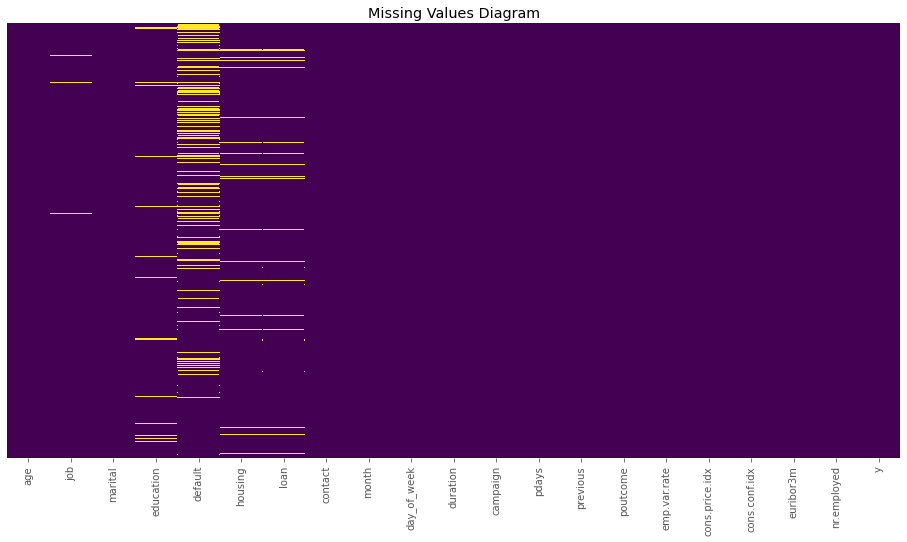

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Missing Values Diagram')
sns.heatmap(((df == 'unknown')), cbar=False,yticklabels=False,cmap = 'viridis');

In [ ]:
((df == 'unknown')).mean().sort_values(ascending=False)

default           0.208726
education         0.042027
housing           0.024036
loan              0.024036
job               0.008012
marital           0.001942
y                 0.000000
day_of_week       0.000000
contact           0.000000
month             0.000000
duration          0.000000
nr.employed       0.000000
campaign          0.000000
pdays             0.000000
previous          0.000000
poutcome          0.000000
emp.var.rate      0.000000
cons.price.idx    0.000000
cons.conf.idx     0.000000
euribor3m         0.000000
age               0.000000
dtype: float64

In [ ]:
(df['pdays'] == 999).mean()

0.9632174419733903

Missing values are marked as **'unknown'**, as can be seen from the description of the dataset. Also, the attribute 'pdays' takes special value 999, and more than 95% of values are 999.

Now we can see, which of the features contain missed values and the proportion of missed values in each predictor. 'Default' feature contains a lot of them and can be the candidate to be removed.

It may be usefull to divide all the feateres into categorical, continuous and ordinal ones. Education can be marked as ordinal, because each level of education can be compared to others, and we can determine the order.

In [ ]:
continious_cols = ['age', 'duration', 'campaign', 'pdays', 'emp.var.rate',
              'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'previous']
categorical_cols = ['job', 'marital' , 'default', 'housing', 'loan', 'day_of_week', 'month', 'contact', 'poutcome' ]
ordinal_cols = ['education']
target = 'y'

## Dropping duplicates

Dropping of duplicates can slighly improve the quality of data. 

In [ ]:
df.drop_duplicates(inplace=True)

## Feature selection and Distribution analysis

In [ ]:
df['y'].value_counts()

no     36537
yes     4639
Name: y, dtype: int64

We can see, that the distribution of the target class is inbalanced. It can be critical in further investigations.

Now we should try to analyse the distributions of different features and find those having near zero variance (**r1** - the ratio of the unique values number to all observations number; **r2** - the ratio of the most frequent value to the second most frequent value). 

In [ ]:
obs_num = df.shape[0]
ratio_list = []
def feature_analysis(df, columns, categorical=False):
    for feature in columns:
        vc = df[feature].value_counts()
        first_most_frequent_val_count = vc.iloc[0]
        second_most_frequent_val_count = vc.iloc[1]
        unique_num = len(df[feature].unique())
        
        print(vc)
        print("Unique values: " + str(unique_num))
        r1 = 100
        if not categorical:
            r1 = round(unique_num / obs_num * 100, 4)
            print("r1 = " + str(r1) + " %")
        r2 = round(first_most_frequent_val_count / second_most_frequent_val_count, 4)
        print("r2 = " + 
              str(r2))
        ratio_list.append((r1, r2, feature))
        print("\n")
        print(40*"-")
        print("\n")
        
print("CONTINIOUS\n")
feature_analysis(df, continious_cols)     
print("CATEGORICAL\n")
feature_analysis(df, categorical_cols + ordinal_cols, categorical=True)     

CONTINIOUS

31    1947
32    1845
33    1833
36    1779
35    1758
      ... 
89       2
91       2
87       1
94       1
95       1
Name: age, Length: 78, dtype: int64
Unique values: 78
r1 = 0.1894 %
r2 = 1.0553


----------------------------------------


85      170
90      170
136     168
73      167
124     163
       ... 
1108      1
980       1
4918      1
2453      1
2015      1
Name: duration, Length: 1544, dtype: int64
Unique values: 1544
r1 = 3.7498 %
r2 = 1.0


----------------------------------------


1     17634
2     10568
3      5340
4      2650
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1

In [ ]:
print('r1')
for f in sorted(ratio_list, key=lambda x: x[0])[:5]:
    print(f'{f[2]} - {f[0]}')
print()
print('r2')
for f in sorted(ratio_list, reverse=True, key=lambda x: x[1])[:5]:
    print(f'{f[2]} - {f[1]}')
#print(sorted(ratio_list, reverse=True, key=lambda x: x[1])[:5])

r1
previous - 0.0194
emp.var.rate - 0.0243
nr.employed - 0.0267
cons.price.idx - 0.0631
cons.conf.idx - 0.0631

r2
pdays - 90.344
poutcome - 8.361
previous - 7.7946
loan - 5.4318
default - 3.7898


We can see, that every column contains very few unique values, even those marked continious. Because of that, now we should pay more attention to another ratio. So,  we can notice some suspicious features: 'pdays', 'poutcome' and 'previous', having the hishest r2.



## General analysis

In [ ]:
df[df.y == 'yes'].describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000,4639.000000
mean,40.912266,553.256090,2.051951,791.990946,0.492779,-1.233089,93.354577,-39.791119,2.123362,5095.120069
std,13.838838,401.190736,1.666353,403.439220,0.860406,1.623616,0.676592,6.139657,1.742717,87.581640
min,17.000000,37.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,31.000000,253.500000,1.000000,999.000000,0.000000,-1.800000,92.893000,-46.200000,0.849000,5017.500000
50%,37.000000,449.000000,2.000000,999.000000,0.000000,-1.800000,93.200000,-40.400000,1.266000,5099.100000
75%,50.000000,741.500000,2.000000,999.000000,1.000000,-0.100000,93.918000,-36.100000,4.406000,5191.000000
max,98.000000,4199.000000,23.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [ ]:
df[df.y == 'no'].describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,36537.000000,36537.000000,36537.000000,36537.000000,36537.000000,36537.000000,36537.000000,36537.000000,36537.000000,36537.000000
mean,39.910994,220.868079,2.633385,984.109396,0.132414,0.248885,93.603798,-40.593232,3.811482,5176.165690
std,9.897176,207.116178,2.873768,120.674753,0.409254,1.482873,0.559006,4.390759,1.638179,64.570288
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,95.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.405000,5099.100000
50%,38.000000,164.000000,2.000000,999.000000,0.000000,1.100000,93.918000,-41.800000,4.857000,5195.800000
75%,47.000000,279.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.962000,5228.100000
max,95.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [ ]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


We can notice, that there can exist some connection between target and 'duration', 'pdays', 'emp.var.rate' and 'euribor3m'.

## Categorical Data: Analysis

Firstly we can look at the distributions of categorical features vue countplot.

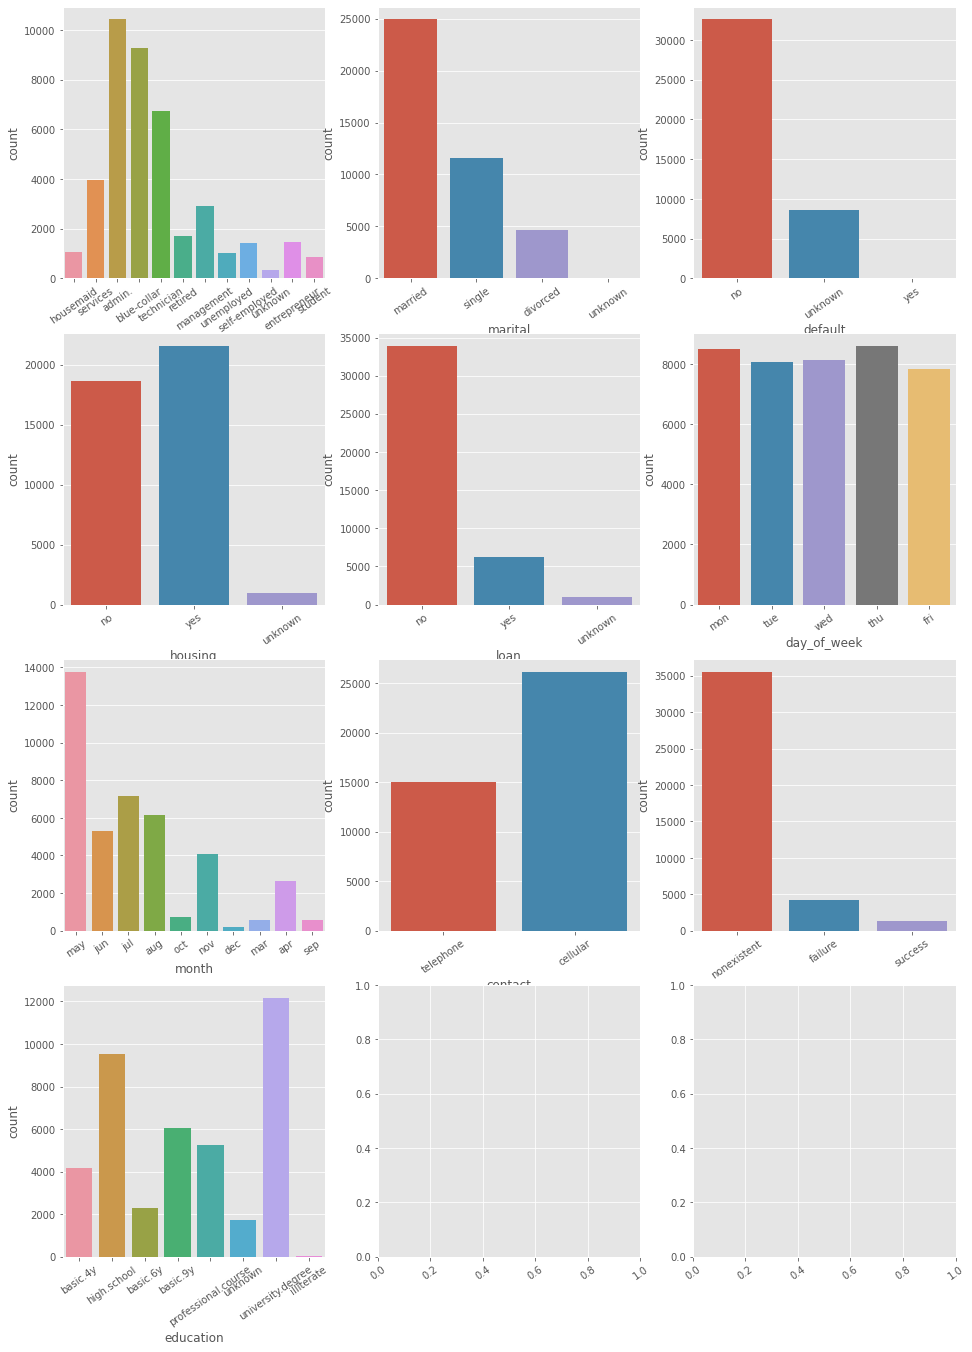

In [ ]:
categorical_len = len(categorical_cols + ordinal_cols)
cols_num = 3

fig, axes = plt.subplots( int(np.ceil(categorical_len / cols_num)) , cols_num,
                         sharex=False, figsize=(16, 7 * categorical_len // cols_num))


for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=35)

for i, feature in enumerate(categorical_cols + ordinal_cols):
    sns.countplot(ax=axes[i // cols_num, i % cols_num], x=feature , data=df);

We can notice very few values 'yes' in the column 'default', less than 'unknown'. We cannot be sure about the content of 'unknown', because of that we should exclude this column in the future.

Next we will try to find any relation between categorical values and the target value with the help of proportion of 'yes' in the target. 

First of all, we should find the share of 'yes' values in the entire dataset to compare with other shares in future.

In [ ]:
y_prop = df['y'].value_counts()['yes'] / (df['y'].value_counts()['yes'] + df['y'].value_counts()['no'])
y_prop

0.11266271614532737

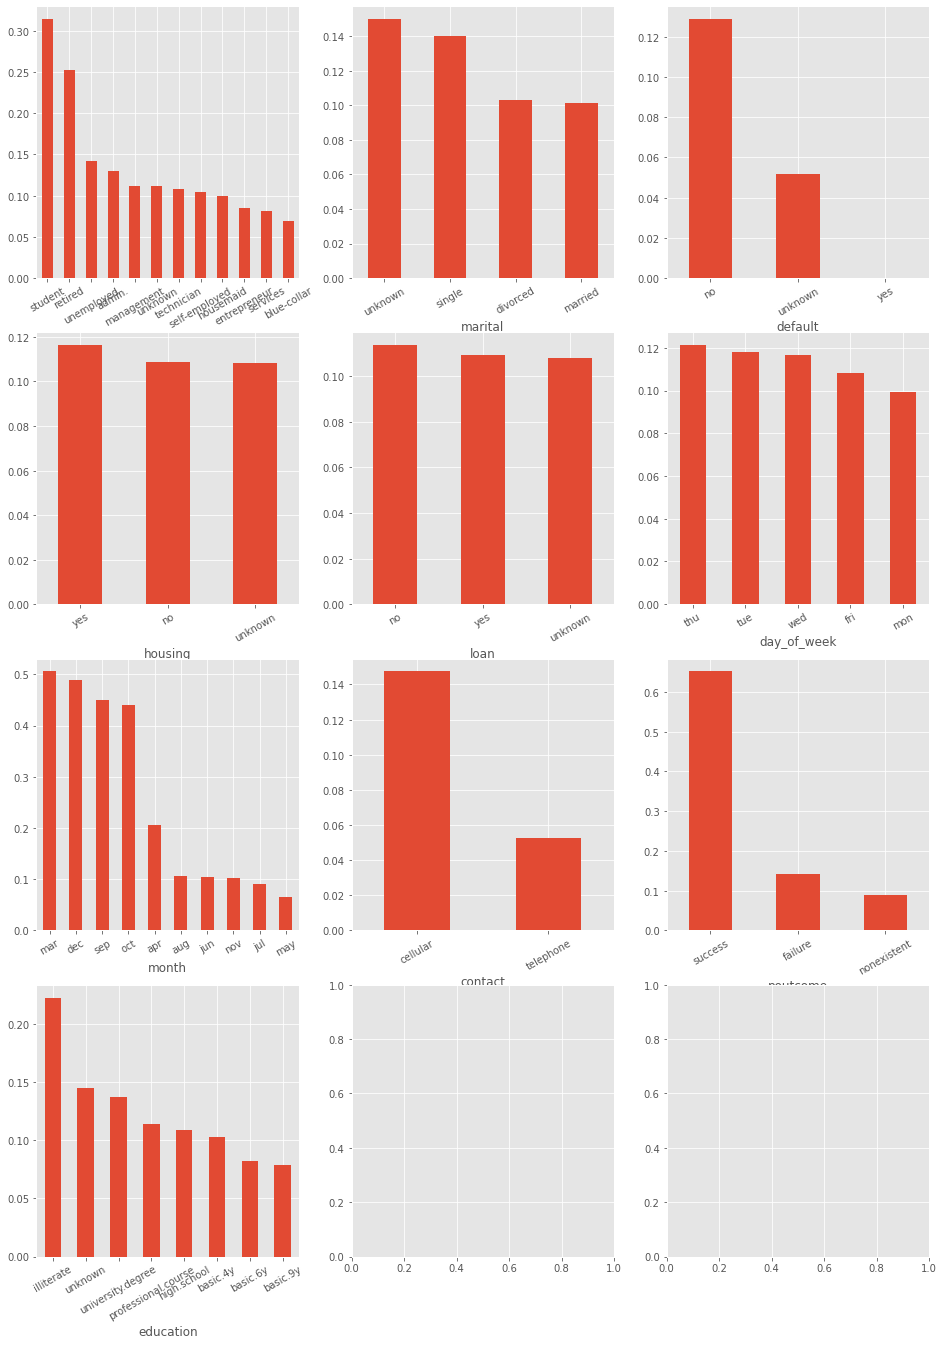

In [ ]:
categorical_len = len(categorical_cols + ordinal_cols)
cols_num = 3

fig, axes = plt.subplots( int(np.ceil(categorical_len / cols_num)) , cols_num,
                         sharey=False, figsize=(16, 7 * categorical_len // cols_num))

for i, feature in enumerate(categorical_cols+ ordinal_cols):
    d = df.groupby([feature, 'y']).y.agg('count').unstack()
    d['prop'] = d['yes']/(d['yes'] + d['no'])
    d.prop.sort_values(ascending=False).plot.bar(ax=axes[i // cols_num, i % cols_num], rot=30);


1. We can see, that 'loan' and 'housing' almost doesn't affect the target value.
2. We can see a large gap in target value proportion between 'no' and 'unknown' features in the graph of 'loan'. But this column doesn't look reliable, because the second most frequent value is 'unknown'.
3. We can see a significant difference in proporions in the graph of 'month'.
4. Other features also show some relation to target value.

It is also important to take into account the proportion inside categories (there could be to little data under some labels  to make assumptions).

In [ ]:
y_prop = df['y'].value_counts()['yes'] / (df['y'].value_counts()['yes'] + df['y'].value_counts()['no'])
print('y_prop = ', round(y_prop * 100, 2), '%')
for feature in categorical_cols + ordinal_cols:
    #plt.figure(figsize=(16, 5))
    d = df.groupby([feature, 'y']).y.agg('count').unstack()
    d['total'] = d['yes'] + d['no']
    d['prop %'] = round(d['yes']/( d['total']) * 100, 2)
    
    #print('\n')
    display(d.sort_values(ascending=False, by='prop %'))
    #plt.show()

y_prop =  11.27 %


y,no,yes,total,prop %
job,,,,
student,600,275,875,31.43
retired,1284,434,1718,25.26
unemployed,870,144,1014,14.20
admin.,9068,1351,10419,12.97
management,2596,328,2924,11.22
unknown,293,37,330,11.21
technician,6009,730,6739,10.83
self-employed,1272,149,1421,10.49
housemaid,954,106,1060,10.00


y,no,yes,total,prop %
marital,,,,
unknown,68,12,80,15.00
single,9944,1620,11564,14.01
divorced,4135,476,4611,10.32
married,22390,2531,24921,10.16


y,no,yes,total,prop %
default,,,,
no,28381.0,4196.0,32577.0,12.88
unknown,8153.0,443.0,8596.0,5.15
yes,3.0,NaN,NaN,NaN


y,no,yes,total,prop %
housing,,,,
yes,19064,2507,21571,11.62
no,16590,2025,18615,10.88
unknown,883,107,990,10.81


y,no,yes,total,prop %
loan,,,,
no,30089,3849,33938,11.34
yes,5565,683,6248,10.93
unknown,883,107,990,10.81


y,no,yes,total,prop %
day_of_week,,,,
thu,7574,1044,8618,12.11
tue,7133,953,8086,11.79
wed,7185,949,8134,11.67
fri,6980,846,7826,10.81
mon,7665,847,8512,9.95


y,no,yes,total,prop %
month,,,,
mar,270,276,546,50.55
dec,93,89,182,48.90
sep,314,256,570,44.91
oct,402,315,717,43.93
apr,2092,539,2631,20.49
aug,5521,655,6176,10.61
jun,4759,559,5318,10.51
nov,3684,416,4100,10.15
jul,6521,648,7169,9.04


y,no,yes,total,prop %
contact,,,,
cellular,22283,3852,26135,14.74
telephone,14254,787,15041,5.23


y,no,yes,total,prop %
poutcome,,,,
success,479,894,1373,65.11
failure,3647,605,4252,14.23
nonexistent,32411,3140,35551,8.83


y,no,yes,total,prop %
education,,,,
illiterate,14,4,18,22.22
unknown,1479,251,1730,14.51
university.degree,10495,1669,12164,13.72
professional.course,4645,595,5240,11.35
high.school,8481,1031,9512,10.84
basic.4y,3748,428,4176,10.25
basic.6y,2103,188,2291,8.21
basic.9y,5572,473,6045,7.82


## Categorical Data: Missed value processing and dropping columns

Columns housing and loan can be excluded for the first time, because they probably poorly influence the target value. As it was mentioned before, default has too many missed values and looks unreliable, so we can drop it.

In [ ]:
df.drop(['housing', 'loan', 'default'], axis=1, inplace=True)
for f in ['housing', 'loan', 'default']:
    categorical_cols.remove(f)

We will fill missed value with mode, if their amount is small (marital). Also we need to process missed values for ordinal data. In other cases we can leave 'unknown' values.

In [ ]:
from sklearn.impute import SimpleImputer

most_frequent_imputer = SimpleImputer(
    missing_values='unknown',
    strategy='most_frequent',
    verbose=True
)

In [ ]:
df[['marital', 'education']] = most_frequent_imputer.fit_transform(df[['marital', 'education']] )

## Continious data: Analysis and Outliers Detection

Now we can analyse the distribution of continuous features with the help of violinplots and boxplots. Violinplots can be more informative about distribution, than boxplot.

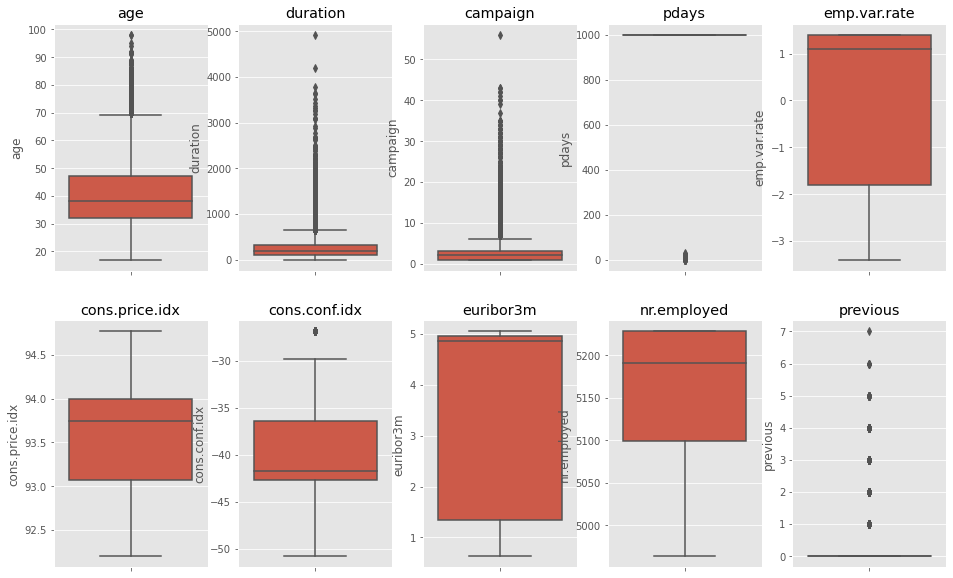

In [ ]:
continious_len = len(continious_cols)
cols_num = 5

fig, axes = plt.subplots( int(np.ceil(continious_len / cols_num)) , cols_num,
                         sharex=False, figsize=(16, 5 * continious_len // cols_num))


for i, feature in enumerate(continious_cols):
    sns.boxplot(ax=axes[i // cols_num, i % cols_num], y=feature , data=df);
    axes[i // cols_num, i % cols_num].set_title(feature)

It seems that our data doesn't containt outliers (incorrect data), but contains anomal data. 

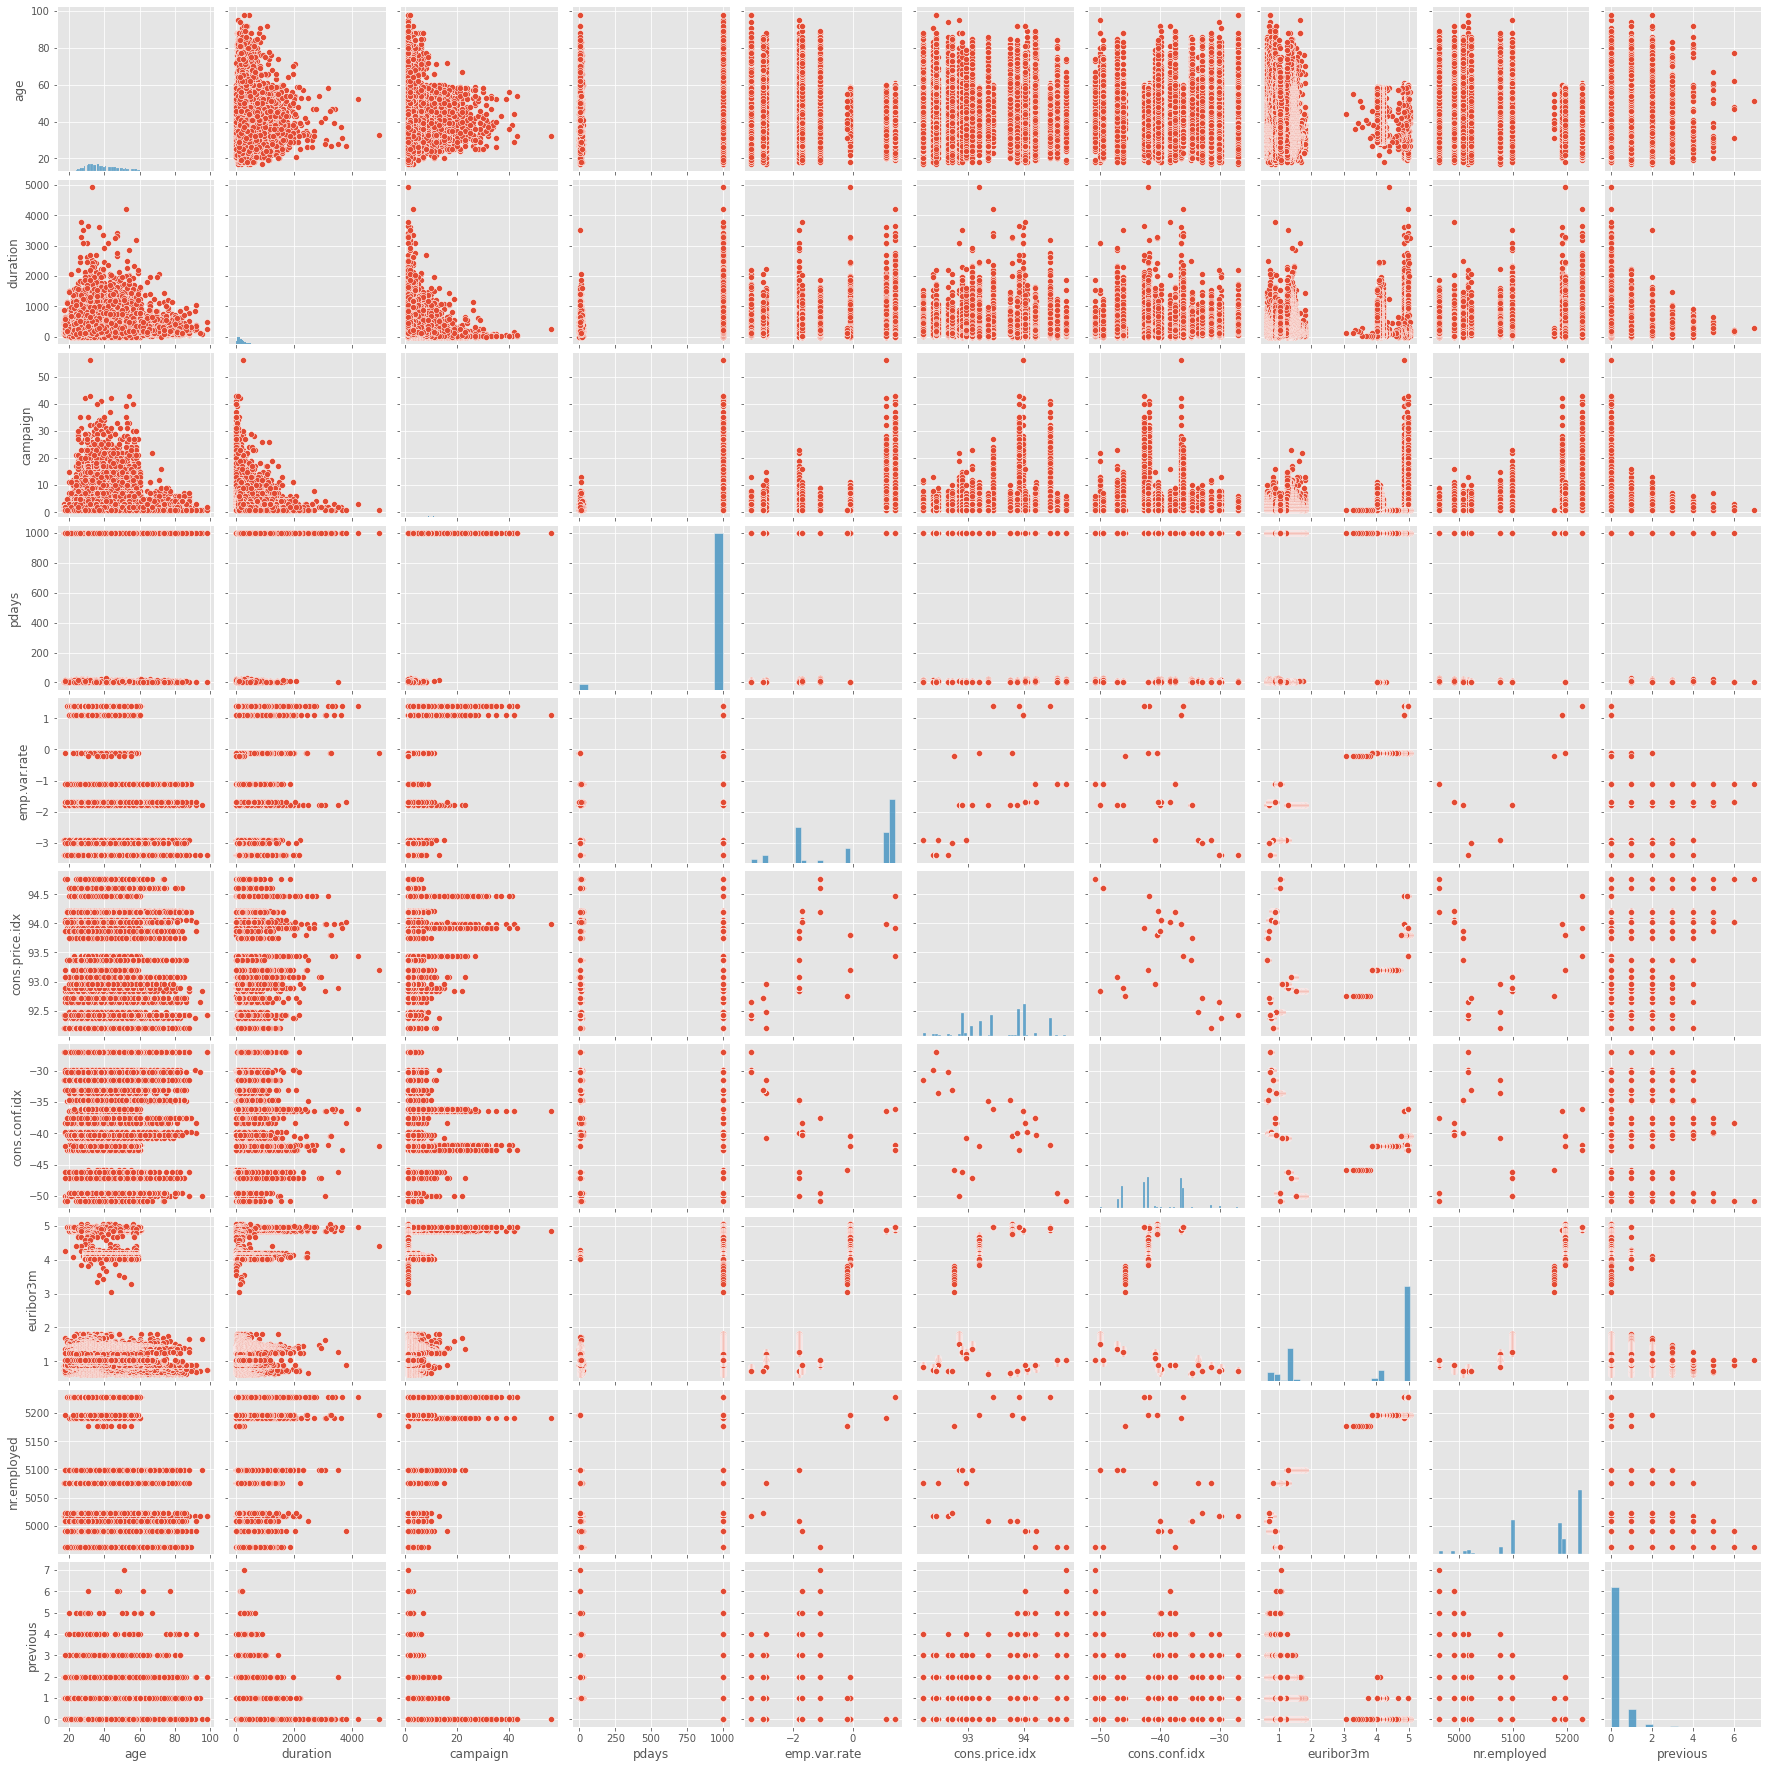

In [ ]:
sns.pairplot(df[continious_cols]);

We can notice some outliers in campaign and duration. Deal with them.


In [ ]:
df[df['duration'] > 2800] = np.nan
df[df['campaign'] > 40] = np.nan
df.dropna(inplace=True)

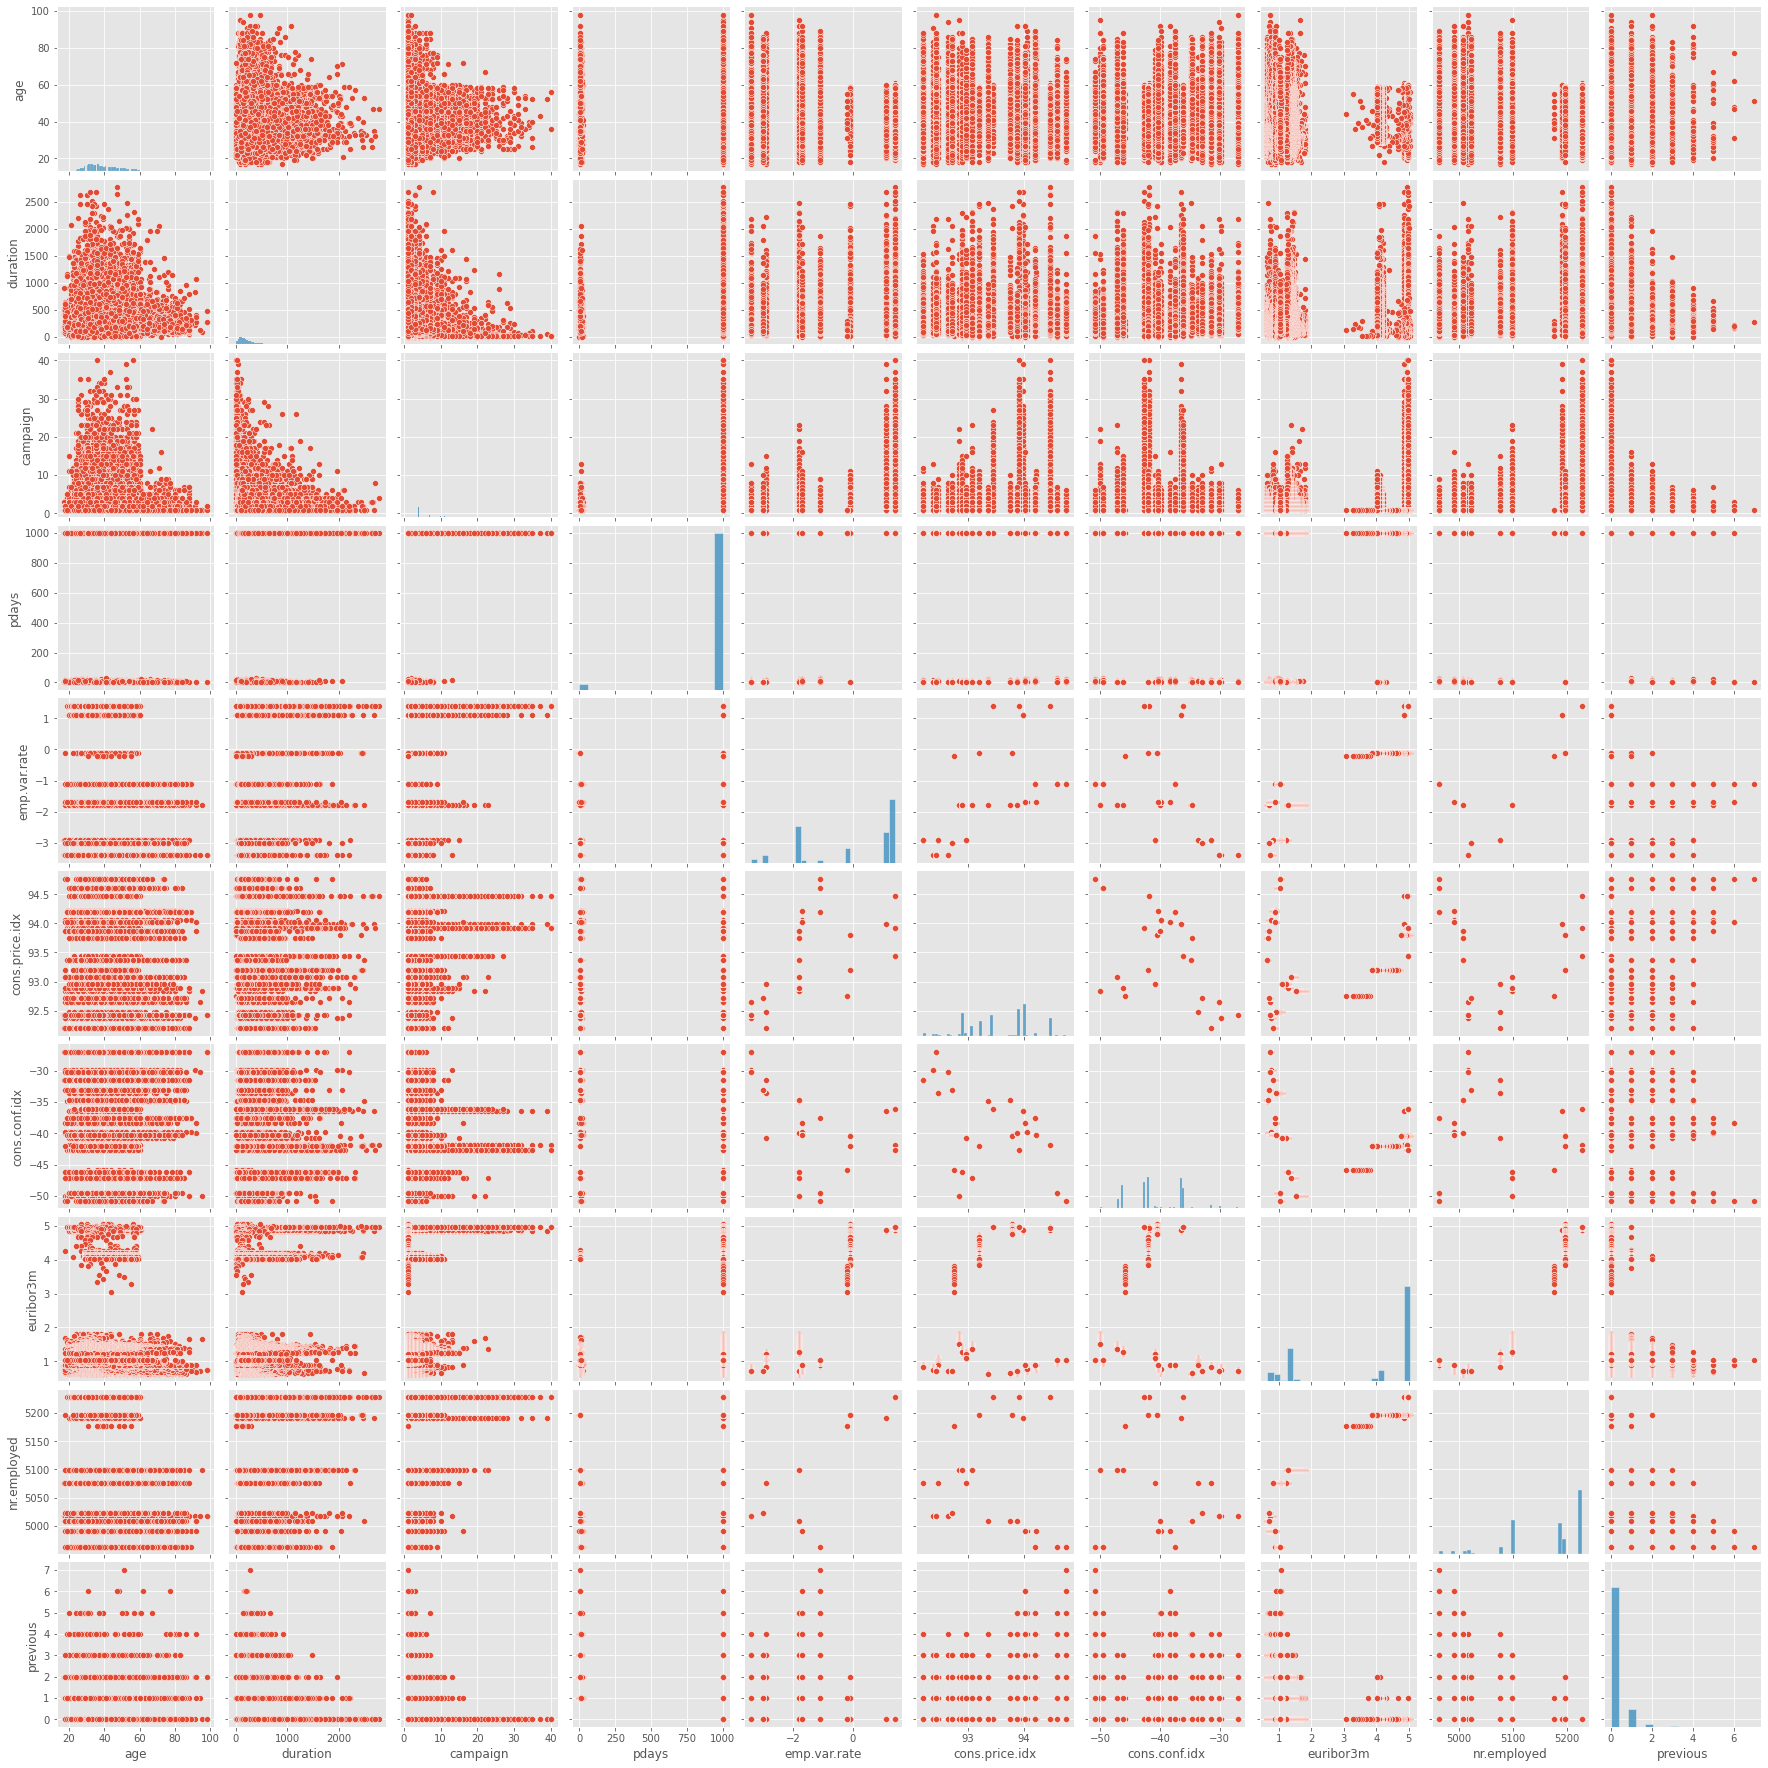

In [ ]:
sns.pairplot(df[continious_cols]);

We can notice, that some features have almost descrete nature, despite they look like continiuous.

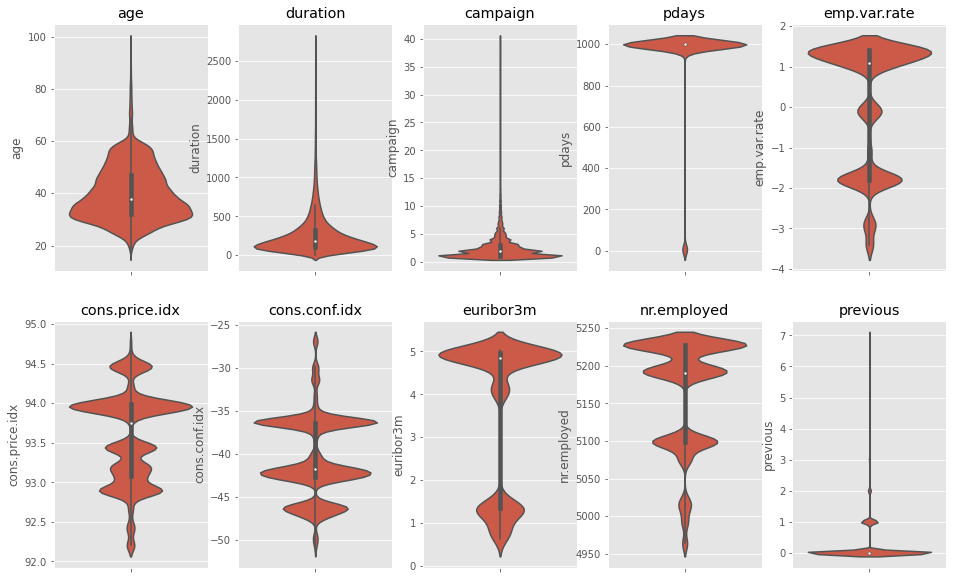

In [ ]:
continious_len = len(continious_cols)
cols_num = 5

fig, axes = plt.subplots( int(np.ceil(continious_len / cols_num)) , cols_num,
                         sharex=False, figsize=(16, 5 * continious_len // cols_num))


for i, feature in enumerate(continious_cols):
    sns.violinplot(ax=axes[i // cols_num, i % cols_num], y=feature , data=df);
    axes[i // cols_num, i % cols_num].set_title(feature)

Distributions of most of the features doesn't look normal. 

We will apply log transformation in order to make 'duration' look more like normal.

In [ ]:
df['duration'] = df['duration'].apply(lambda x: np.log(1 + x))

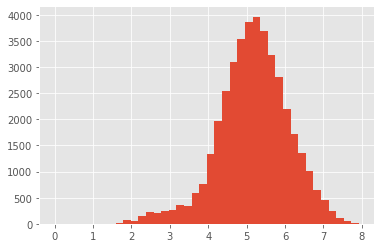

In [ ]:
df['duration'].hist(bins=40)

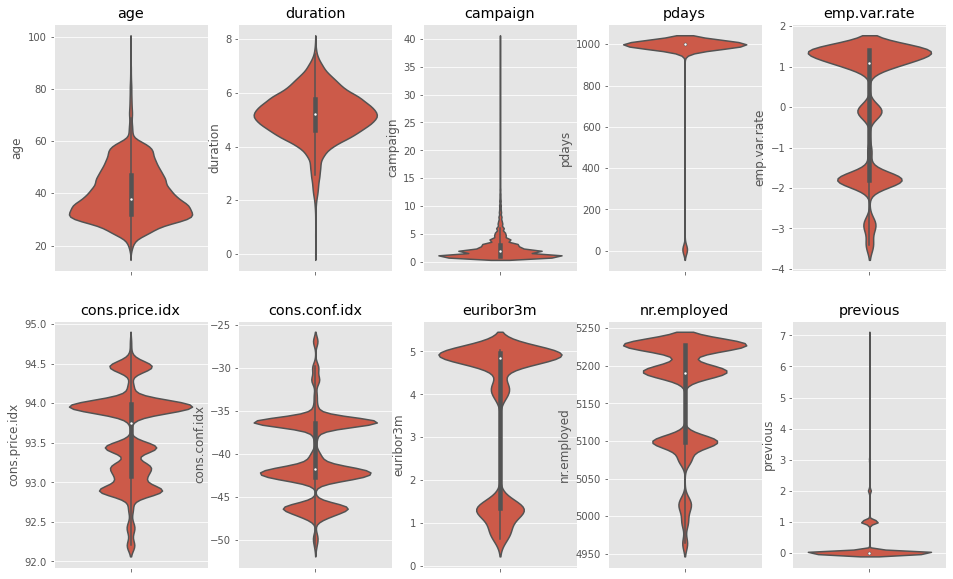

In [ ]:
continious_len = len(continious_cols)
cols_num = 5

fig, axes = plt.subplots( int(np.ceil(continious_len / cols_num)) , cols_num,
                         sharex=False, figsize=(16, 5 * continious_len // cols_num))


for i, feature in enumerate(continious_cols):
    sns.violinplot(ax=axes[i // cols_num, i % cols_num], y=feature , data=df);
    axes[i // cols_num, i % cols_num].set_title(feature)

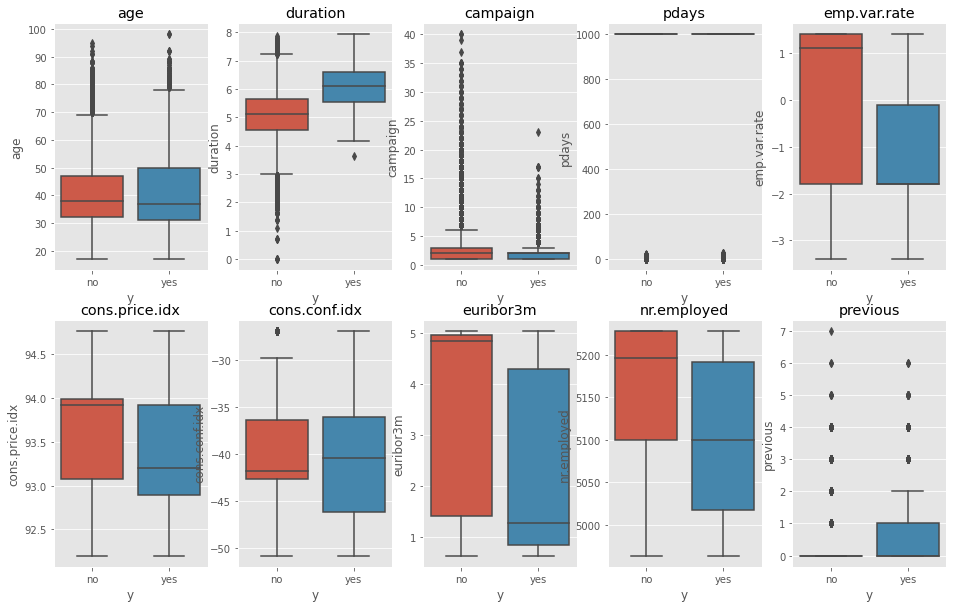

In [ ]:
continious_len = len(continious_cols)
cols_num = 5

fig, axes = plt.subplots( int(np.ceil(continious_len / cols_num)) , cols_num,
                         sharex=False, figsize=(16, 5 * continious_len // cols_num))

for i, feature in enumerate(continious_cols):
    sns.boxplot(ax=axes[i // cols_num, i % cols_num], x='y', y=feature , data=df);
    axes[i // cols_num, i % cols_num].set_title(feature)

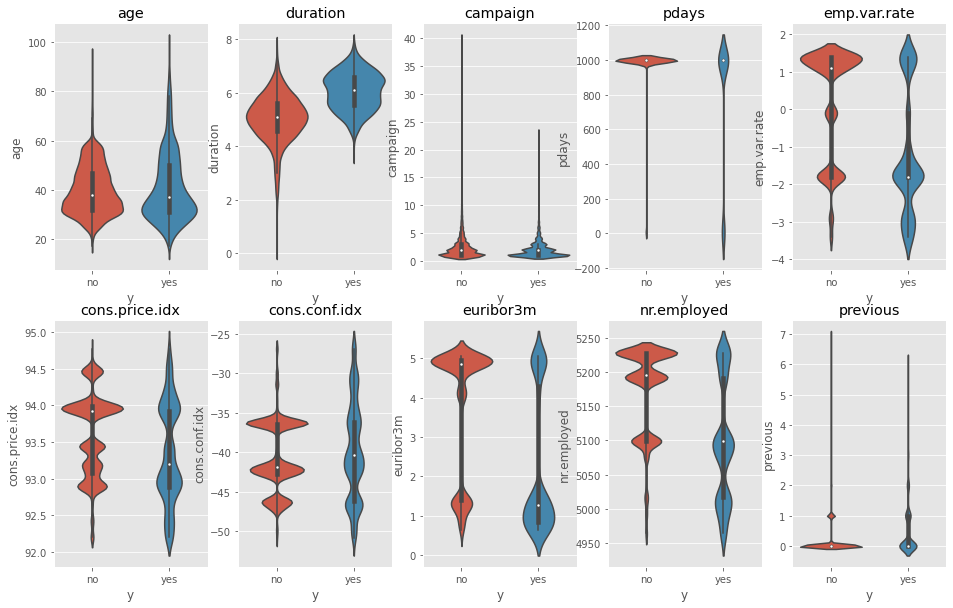

In [ ]:
continious_len = len(continious_cols)
cols_num = 5

fig, axes = plt.subplots( int(np.ceil(continious_len / cols_num)) , cols_num,
                         sharex=False, figsize=(16, 5 * continious_len // cols_num))


for i, feature in enumerate(continious_cols):
    mean = df[feature].mean()
    std = df[feature].std()
    sns.violinplot(ax=axes[i // cols_num, i % cols_num], x='y', y=feature , data=df);
    axes[i // cols_num, i % cols_num].set_title(feature)

We can see, that  some features have significant difference between medians (duration, emp.var.rate, cons.price.idx, etc).

## Correlation Matrix

Also, we can check for highly correlated features and drop some of them.

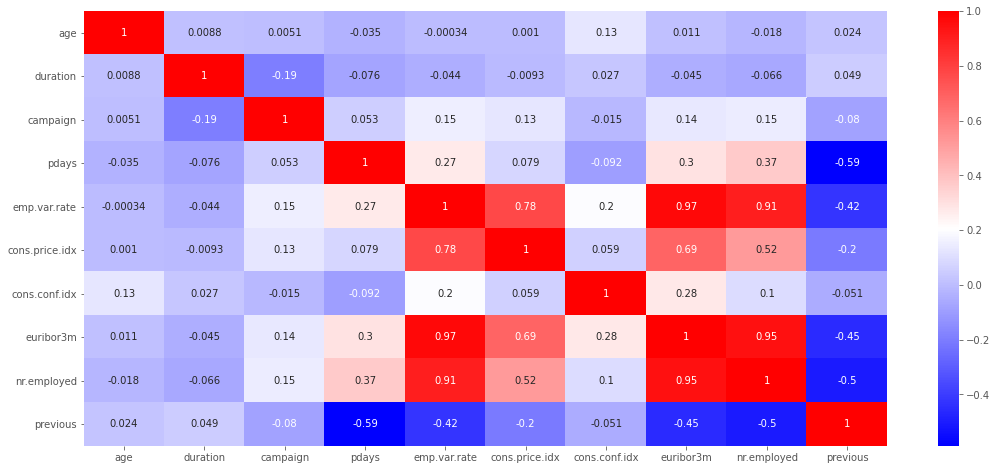

In [ ]:
plt.figure(figsize=(18,8))
sns.heatmap(df[continious_cols].corr(),cmap='bwr',annot=True);

emp.var.rate highly correlated to cons.price.ids, euribor3m and nr.employed. Some other features are too highly correlated, and we can drop them.

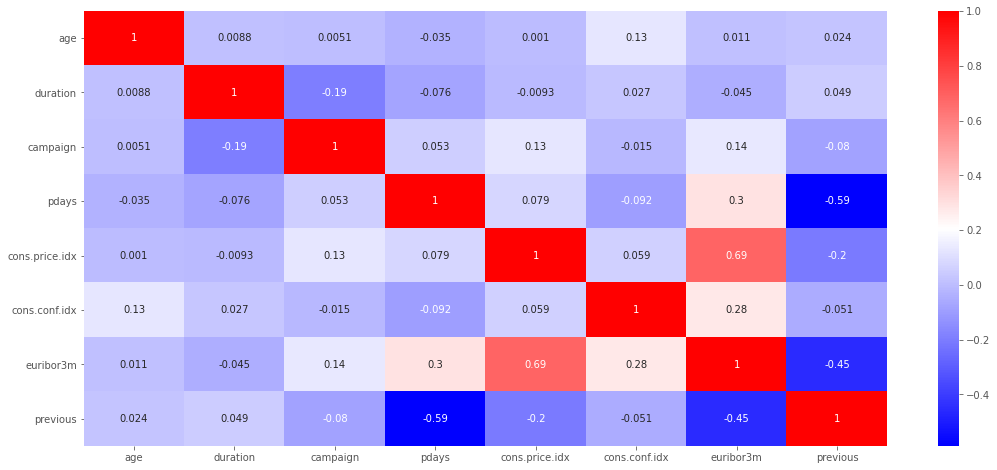

In [ ]:
plt.figure(figsize=(18,8))
sns.heatmap(df[continious_cols].drop(['emp.var.rate', 'nr.employed'], axis=1).corr(),cmap='bwr',annot=True);

Now the correlation table looks better.

In [ ]:
df.drop(['emp.var.rate', 'nr.employed'], axis=1, inplace=True)
continious_cols.remove('emp.var.rate')
continious_cols.remove('nr.employed')

## Data preparation: categorical data encoding, normalization and standardization

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

In [ ]:
edu_encoding = {
    'illiterate' : 0,
    'basic.4y' : 1,
    'basic.6y' : 2,
    'basic.9y' : 3,
    'high.school' : 4,
    'professional.course' : 5,
    'university.degree' : 6,
}

df['education'] = df['education'].map(edu_encoding)

In [ ]:
# Define pipelines for preprocessing different types of features
minMaxList = list(set(continious_cols).difference('duration'))


num_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('variance_trsh', VarianceThreshold(threshold=0.1))
    
])

num_std_pipe = Pipeline([
    ('scaler', StandardScaler()),
])

cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(sparse=False)), 
    ('variance_trsh', VarianceThreshold(threshold=.97 * (1 - .97)))
])


ord_pipe = Pipeline([
    ('scaler', StandardScaler()),
])

pipe = ColumnTransformer(transformers=[
    ('cat', cat_pipe, categorical_cols),
    ('ord', ord_pipe, ordinal_cols),
    ('num_std', num_std_pipe, ['duration']),
    ('num_mm', num_pipe, minMaxList)
], verbose=True)

In [ ]:
X = pipe.fit_transform(df.iloc[:, :-1])

[ColumnTransformer] ........... (1 of 4) Processing cat, total=   0.1s
[ColumnTransformer] ........... (2 of 4) Processing ord, total=   0.0s
[ColumnTransformer] ....... (3 of 4) Processing num_std, total=   0.0s
[ColumnTransformer] ........ (4 of 4) Processing num_mm, total=   0.0s


In [ ]:
#!pip install umap-learn

# DR

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import umap

In [ ]:
X.shape

(41153, 30)

### PCA

In [ ]:
pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

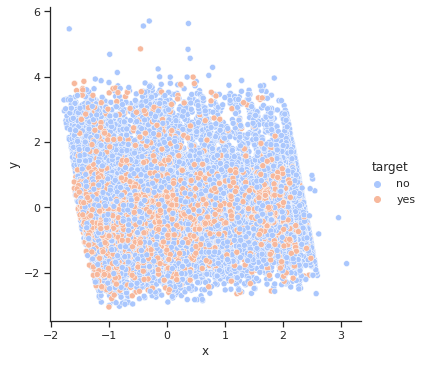

In [ ]:
plot_df = pd.DataFrame.from_records(data=new_X[:,:2],columns=["x","y"])
plot_df["target"] = df['y']

sns.set(style="ticks")
sns.relplot(x="x", y="y", data=plot_df, hue="target", palette='coolwarm');

**Explained variance**

In [ ]:
pca.explained_variance_ratio_.sum()

0.37301528935991807

**Optimal number of components**

In [ ]:
pca = PCA(n_components=0.95).fit(X)
len(pca.explained_variance_ratio_)

18

### SVD

In [ ]:
svd = TruncatedSVD(n_components=2, algorithm='arpack')
svd_X = svd.fit_transform(X)

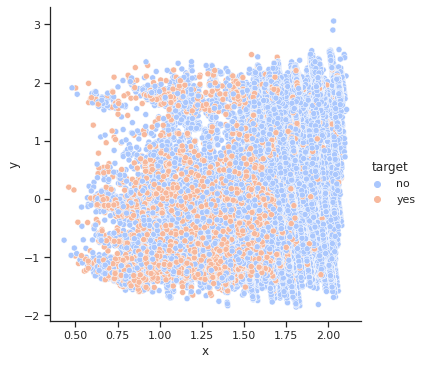

In [ ]:
plot_df = pd.DataFrame.from_records(data=svd_X[:,:2],columns=["x","y"])
plot_df["target"] = df['y']

sns.set(style="ticks")
sns.relplot(x="x", y="y", data=plot_df, hue="target", palette='coolwarm');

**Explained variance**

In [ ]:
svd.explained_variance_ratio_.sum()

0.21535601421328648

### TSNE

In [ ]:
tsne = TSNE()
tsne_X = tsne.fit_transform(X)

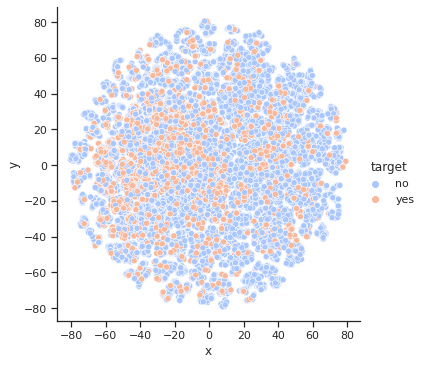

In [ ]:
plot_df = pd.DataFrame.from_records(data=tsne_X,columns=["x","y"])
plot_df["target"] = df['y']

sns.set(style="ticks")
sns.relplot(x="x", y="y", data=plot_df, hue="target", palette='coolwarm');

### UMAP

In [ ]:
embedding = umap.UMAP(n_neighbors=30,
                      min_dist=0.3).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


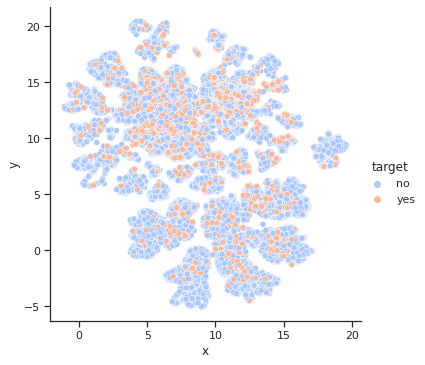

In [ ]:
plot_df = pd.DataFrame.from_records(data=embedding,columns=["x","y"])
plot_df["target"] = df['y']

sns.set(style="ticks")
sns.relplot(x="x", y="y", data=plot_df, hue="target", palette='coolwarm');

## Conclusion

* The distribution of the target value is inbalanced. Probably, it may require special techniques to improve the results of ML algorithms, if needed.
* There were noticed some highly correlated fetures in the dataset (mainly ratings & indexes).
* For visualization of multi-dimensional data were used special algorithms, but they didn't divided data into classes noticeably.
* About 95 of dispersion explained by 18 components using PCA. Probably we can reduce fetures number or introduce some new features, if needed.
* Some features often take specific values, although they look like continious (it can be seen on violinplots and pairplots).